In [7]:
import wandb
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
from train_utils import update_dir_name, get_default_configs
font_path = 'analyses/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Get wandb run history
api = wandb.Api()
wandb_path = os.path.join("..", "wandb")

In [8]:
training_config, model_config, cluster_config = get_default_configs(random_string="TEMP", wandb_project="btbank_tests")


In [12]:
learning_rates = sorted([0.0021, 0.003, 0.0042, 0.006])
symmetric_loses = [0, 1]
random_strings = ["SL1", "SL2", "SL3"]

condition_str = [f"{sl}_{lr}" for sl in symmetric_loses for lr in learning_rates]

# Initialize histories dict
histories = {cs: [] for cs in condition_str}

# Generate all run IDs and collect histories
for cs in condition_str:
    for rs in random_strings:
        training_config['random_string'] = rs
        training_config['symmetric_loss'] = int(cs.split("_")[0])
        training_config['learning_rate'] = float(cs.split("_")[1])

        run_id = update_dir_name(model_config, training_config, cluster_config)
        
        runs = api.runs("andrii-mit/btbank_tests", filters={"display_name": run_id})
        if len(runs) > 0:
            run = runs[0]
            history = run.history()
            if '_step' not in history.columns:
                print(f"Run {run_id} has no '_step' column")
                continue
            if history['_step'].max() == 100:  # Only include if trained for full 100 epochs
                histories[cs].append(history)
            else:
                print(f"Run {run_id} did not train for full 100 epochs")

for cs in condition_str:
    print(f"condition {cs}: {len(histories[cs])} runs")

Run M_nst8_dm192_nh12_nl5_5_nSL_lr0.006_rSL1 did not train for full 100 epochs
Run M_nst8_dm192_nh12_nl5_5_nSL_lr0.006_rSL2 did not train for full 100 epochs
Run M_nst8_dm192_nh12_nl5_5_nSL_lr0.006_rSL3 did not train for full 100 epochs
Run M_nst8_dm192_nh12_nl5_5_lr0.003_rSL2 did not train for full 100 epochs
Run M_nst8_dm192_nh12_nl5_5_lr0.0042_rSL1 did not train for full 100 epochs
Run M_nst8_dm192_nh12_nl5_5_lr0.0042_rSL3 did not train for full 100 epochs
condition 0_0.0021: 3 runs
condition 0_0.003: 3 runs
condition 0_0.0042: 3 runs
condition 0_0.006: 0 runs
condition 1_0.0021: 3 runs
condition 1_0.003: 2 runs
condition 1_0.0042: 1 runs
condition 1_0.006: 3 runs


In [32]:
metrics = ['train_loss', 'test_loss', 'eval_auroc/average_speech', 'eval_auroc/average_volume']
metric_names = ['Training Loss', 'Test Loss', 'Decoding Speech AUROC', 'Decoding Volume AUROC']
n_last_measurements = 3
measurement_at = 20

# Initialize results dictionary
results = {cs: {metric: [] for metric in metrics} 
          for cs in condition_str}

# Calculate means for each run
for cs in condition_str:
    for history in histories[cs]:
        for metric in metrics:
            h = np.array(list(history[metric].iloc))
            h = h[~np.isnan(h)]
            results[cs][metric].append(h[-n_last_measurements+measurement_at:measurement_at].mean())

# Print results
for cs in condition_str:
    print(f"\ncs {cs}:")
    for metric in metrics:
        values = results[cs][metric]
        if values:
            mean = sum(values) / len(values)
            print(f"{metric}: {mean:.4f} (across {len(values)} runs)")



cs 0_0.0021:
train_loss: 1.1349 (across 3 runs)
test_loss: 1.0521 (across 3 runs)
eval_auroc/average_speech: 0.8519 (across 3 runs)
eval_auroc/average_volume: 0.7465 (across 3 runs)

cs 0_0.003:
train_loss: 0.8422 (across 3 runs)
test_loss: 0.7982 (across 3 runs)
eval_auroc/average_speech: 0.8575 (across 3 runs)
eval_auroc/average_volume: 0.7489 (across 3 runs)

cs 0_0.0042:
train_loss: 0.7039 (across 3 runs)
test_loss: 0.6641 (across 3 runs)
eval_auroc/average_speech: 0.8542 (across 3 runs)
eval_auroc/average_volume: 0.7393 (across 3 runs)

cs 0_0.006:

cs 1_0.0021:
train_loss: 0.9210 (across 3 runs)
test_loss: 0.8607 (across 3 runs)
eval_auroc/average_speech: 0.8586 (across 3 runs)
eval_auroc/average_volume: 0.7441 (across 3 runs)

cs 1_0.003:
train_loss: 0.6435 (across 2 runs)
test_loss: 0.6204 (across 2 runs)
eval_auroc/average_speech: 0.8782 (across 2 runs)
eval_auroc/average_volume: 0.7419 (across 2 runs)

cs 1_0.0042:
train_loss: 0.4623 (across 1 runs)
test_loss: 0.4538 (across

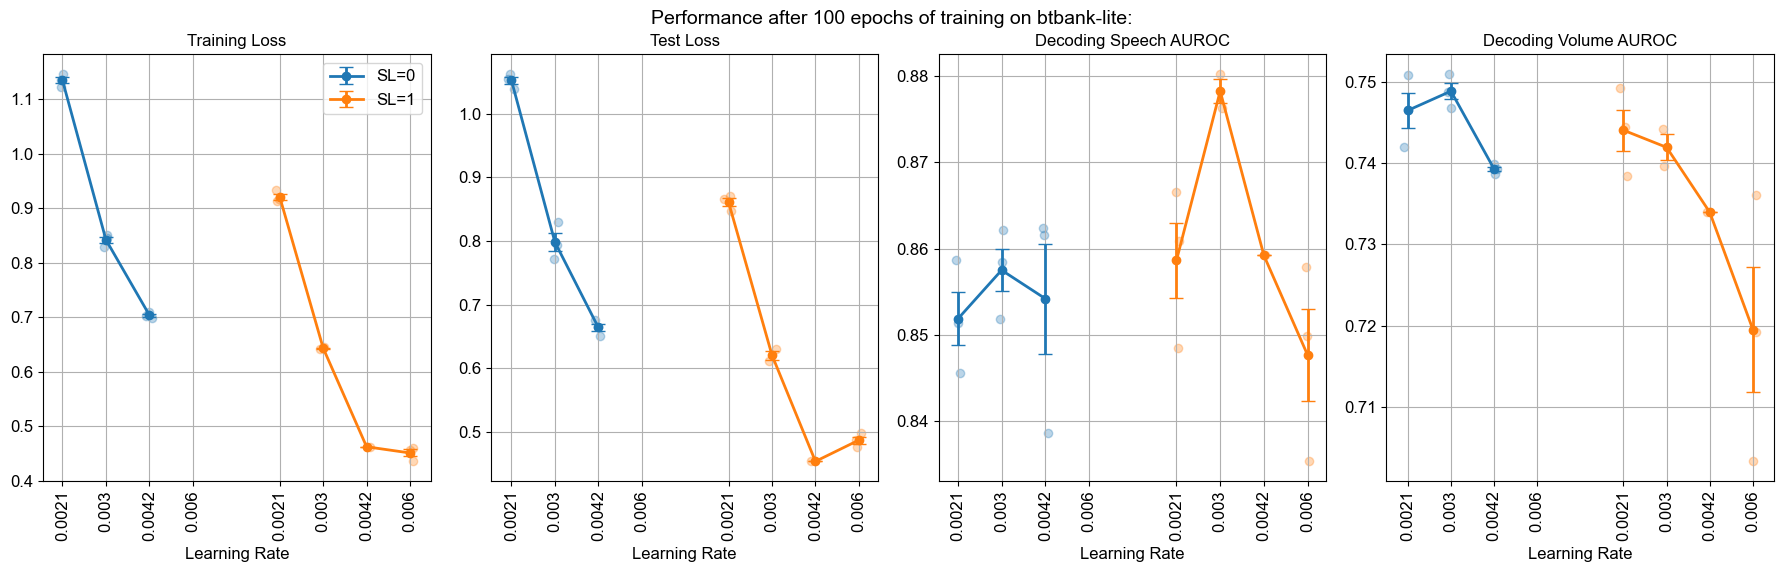

In [33]:
# Set error bar type ('std' for standard deviation or 'sem' for standard error of mean)
error_type = 'sem'

fig, axes = plt.subplots(1, len(metrics), figsize=(4.5*len(metrics), 6))

for i, metric in enumerate(metrics):
    for sl_idx, sl in enumerate(symmetric_loses):
        means = []
        errors = []
        ps = []
        all_values = []
        all_ps = []
        
        # Calculate base x position for this batch size group
        base_x = sl_idx * (len(learning_rates) + 1)  # +1 for spacing between groups
        
        # Get data for each learning rate within this batch size
        for lr_idx, lr in enumerate(learning_rates):
            cs = f"{sl}_{lr}"  # Reconstruct condition string
            values = results[cs][metric] if cs in results else []
            
            if values:
                means.append(np.mean(values))
                if error_type == 'std':
                    errors.append(np.std(values))
                else:  # sem
                    errors.append(np.std(values) / np.sqrt(len(values)))
                
                x_ind = base_x + lr_idx
                ps.append(x_ind)
                
                # Store individual points
                all_values.extend(values)
                all_ps.extend([x_ind] * len(values))
        
        # Plot individual points with some jitter and transparency
        jitter = 0.1
        axes[i].scatter(
            [p + np.random.uniform(-jitter, jitter) for p in all_ps],
            all_values,
            alpha=0.3,
            color=f'C{sl_idx}',
            zorder=1
        )
        
        # Plot mean and error bars for this batch size group
        if means:  # Only plot if we have data
            error_label = f'SL={sl}'
            axes[i].errorbar(ps, means, yerr=errors, marker='o', capsize=5, 
                        color=f'C{sl_idx}', zorder=2, label=error_label,
                        linewidth=2)
    
    # Set x-ticks and labels for learning rates
    all_x_ticks = []
    all_x_labels = []
    for sl_idx, sl in enumerate(symmetric_loses):
        base_x = sl_idx * (len(learning_rates) + 1)
        all_x_ticks.extend([base_x + i for i in range(len(learning_rates))])
        all_x_labels.extend([f"{lr}" for lr in learning_rates])
    
    axes[i].set_xticks(all_x_ticks, all_x_labels, rotation=90)
    axes[i].set_xlabel('Learning Rate')
    axes[i].set_title(metric_names[i], color='black', fontsize=12)
    axes[i].grid(True)
    if i==0: axes[i].legend()

plt.suptitle('Performance after 100 epochs of training on btbank-lite:', color='black', fontsize=14, y=0.95)
plt.tight_layout()
plt.savefig('analyses/exp_sl.pdf', bbox_inches='tight', dpi=300)
plt.show()
